In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

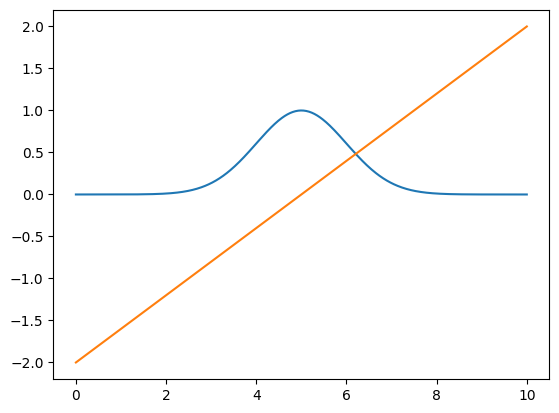

In [6]:
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 1
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*(t / (T_max/2) - 1)

plt.plot(times, omega_t(times))
plt.plot(times, delta_t(times))

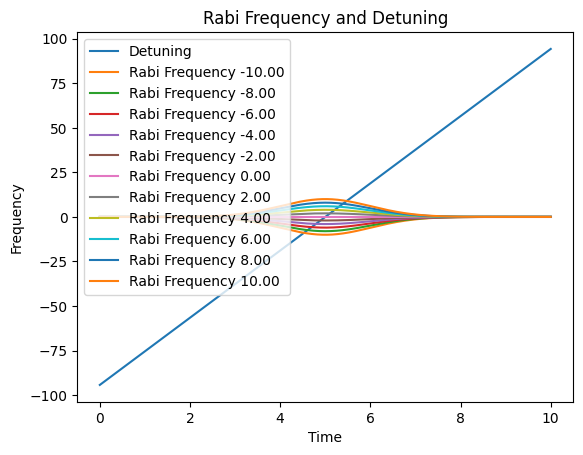

In [7]:
# Example usage ---------------------------------------------------------------
t_max   = 10.0            # µs, say
sigma   = 1.0             # µs
omega_0 = 12.0 * 2*np.pi  #
# 12 MHz peak Rabi frequency
delta_i = -15.0 * 2*np.pi # start detuning (red-detuned)
delta_f = +15.0 * 2*np.pi # end detuning   (blue-detuned)

times = np.linspace(0, t_max, 1000)

import numpy as np

def gaussian_drive(t,               # time (float or np.ndarray)
                   omega_max,       # peak Rabi frequency (rad s⁻¹)
                   t_max,           # total protocol duration
                   sigma):          # std-dev of the Gaussian
    """
    ω(t) = ω_max · exp[ -½ · ((t - t_max/2) / σ)² ]
    """
    return omega_max * np.exp(-0.5 * ((t - t_max/2) / sigma) ** 2)


def linear_detuning(t,              # time (float or np.ndarray)
                    delta_start,    # detuning at t = 0   (rad s⁻¹)
                    delta_end,      # detuning at t = t_max (rad s⁻¹)
                    t_max):         # total protocol duration
    """
    Δ(t) = δ_start + (δ_end - δ_start) · (t / t_max)
    """
    return delta_start + (delta_end - delta_start) * (t / t_max)


omega_t = gaussian_drive(times, omega_0, t_max, sigma)
delta_t = linear_detuning(times, delta_i, delta_f, t_max)

# now plot for different values of rabi frequency
omega_maxs = np.linspace(-10, 10, 11)
plt.plot(times, delta_t, label="Detuning")
for omega_max in omega_maxs:
    omega_t = gaussian_drive(times, omega_max, t_max, sigma)
    plt.plot(times, omega_t, label=f"Rabi Frequency {omega_max:.2f}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Rabi Frequency and Detuning")
plt.legend()
plt.show()

In [8]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

zero = basis(2, 0)
one = X * zero
initial_state = zero

P1 = one*one.dag()

# Checking infidelity of the protocol as a function of the total runtime T
* energy gap protection does not change the infidelity

# Checking infidelity of the protocol as a function of the maximum frequency $\Omega_{max}$
* energy gap protection does not change the infidelity

In [9]:
omega_maxs = np.linspace(-5*10, 5*10, 1000)

T = 10
times = np.linspace(0, T, 50)
infiedelities = {}
sigma = 1

for scale in [10]:
    infiedelities[scale] = []
    for omega_max in tqdm(omega_maxs, desc="Omega Max"):
        omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
        delta_t = lambda t: scale*(t / (T_max/2) - 1)
        def H(t):
            return  X * omega_t(t) + Z * delta_t(t)
        
        results = sesolve(H, zero, times, e_ops=[P1])
        infiedelities[scale].append(results.expect[0][-1])

Omega Max: 100%|██████████| 1000/1000 [00:05<00:00, 185.11it/s]


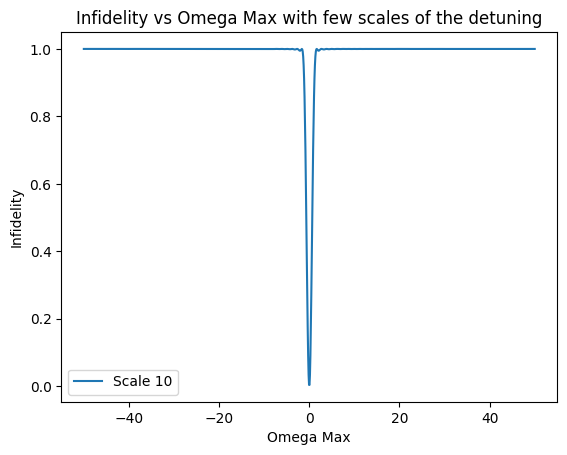

In [10]:
plt.title("Infidelity vs Omega Max with few scales of the detuning")
# plt.plot(omega_maxs, infiedelities, "o")
for scale, infidelity in infiedelities.items():
    plt.plot(omega_maxs, infidelity, label=f"Scale {scale}")

plt.ylabel("Infidelity")
plt.xlabel("Omega Max")
plt.legend()
plt.show()

Running sesolve: 100%|██████████| 500/500 [00:01<00:00, 285.54it/s]
/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_37921/2894002259.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pulse_area = np.trapz(pulse, times)


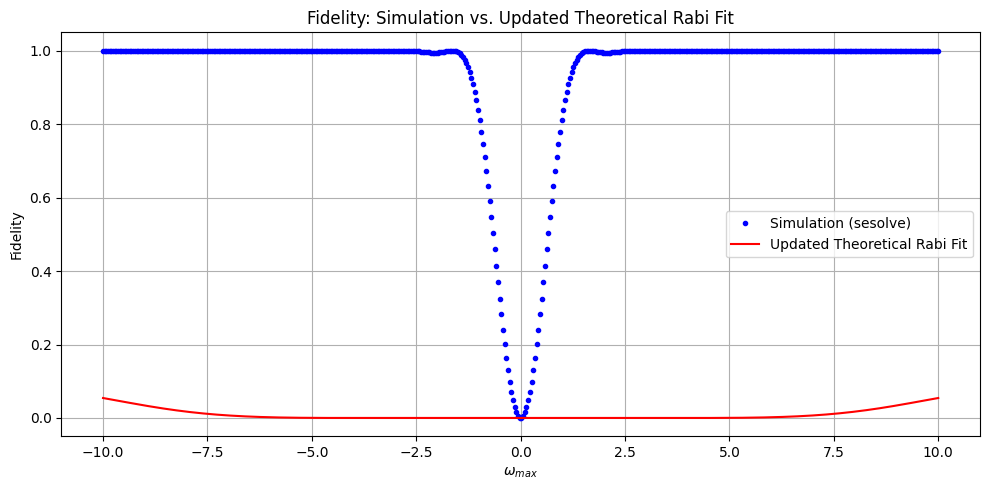

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmax, sigmaz, sesolve
from tqdm import tqdm

# Global simulation parameters
T_max = 10       # Total protocol duration for pulse envelopes
T = 10           # Final time at which fidelity is measured
sigma = 1        # Width of the Gaussian pulse
scale = 10       # Detuning scale factor

# Qutip operators and states
X = sigmax()
Z = sigmaz()
zero = basis(2, 0)       # Initial state |0>
one_unnorm = X * zero
one = one_unnorm.unit()  # Define |1>
P1 = one * one.dag()     # Projector to state |1>

# Time grid for simulation
times = np.linspace(0, T, 50)

# Define the pulse envelopes (they are used later inside the loop)
def omega_t_func(om, t):
    return om * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)

def delta_t_func(t):
    return scale * (t / (T_max/2) - 1)

# Run simulation for omega_max ranging from -10 to 10
omega_maxs = np.linspace(-10, 10, 500)
sim_fidelity = []

for om in tqdm(omega_maxs, desc="Running sesolve"):
    # Define time-dependent functions for the given om
    omega_t = lambda t: omega_t_func(om, t)
    delta_t = lambda t: delta_t_func(t)
    H = lambda t, args: X * omega_t(t) + Z * delta_t(t)
    result = sesolve(H, zero, times, e_ops=[P1])
    sim_fidelity.append(result.expect[0][-1])

# --- Updated Theoretical fit ---
# Instead of evaluating the drive only at T, we compute an effective drive strength
# via integrating the pulse envelope over the entire pulse duration.
def effective_omega(om):
    pulse = omega_t_func(om, times)
    pulse_area = np.trapz(pulse, times)
    return pulse_area / T

# Detuning is assumed to be constant, taken as its value at T.
delta_eff = delta_t_func(T)

def rabi_population(T_val, eff_Omega, delta):
    arg = 0.5 * T_val * np.sqrt(eff_Omega**2 + delta**2)
    return (eff_Omega**2 / (eff_Omega**2 + delta**2)) * np.sin(arg)**2

theo_fidelity = []
for om in omega_maxs:
    eff_Omega = effective_omega(om)
    # Since the simulation fidelity is the final population in state |1>,
    # we assume the ideal transfer is given by the Rabi formula.
    pop = rabi_population(T, eff_Omega, delta_eff)
    theo_fidelity.append(pop)

# Plot both simulation and updated theoretical fit
plt.figure(figsize=(10, 5))
plt.plot(omega_maxs, sim_fidelity, 'b.', label="Simulation (sesolve)")
plt.plot(omega_maxs, theo_fidelity, 'r-', label="Updated Theoretical Rabi Fit")
plt.xlabel(r'$\omega_{max}$')
plt.ylabel("Fidelity")
plt.title("Fidelity: Simulation vs. Updated Theoretical Rabi Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_53420/618178388.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau_eff = np.trapz(env, times)
/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_53420/618178388.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eff_delta_val = np.trapz(delta_t_func(times) * env, times) / tau_eff
Running sesolve: 100%|██████████| 500/500 [00:04<00:00, 121.46it/s]
/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_53420/618178388.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(pulse * env, times) / tau_eff


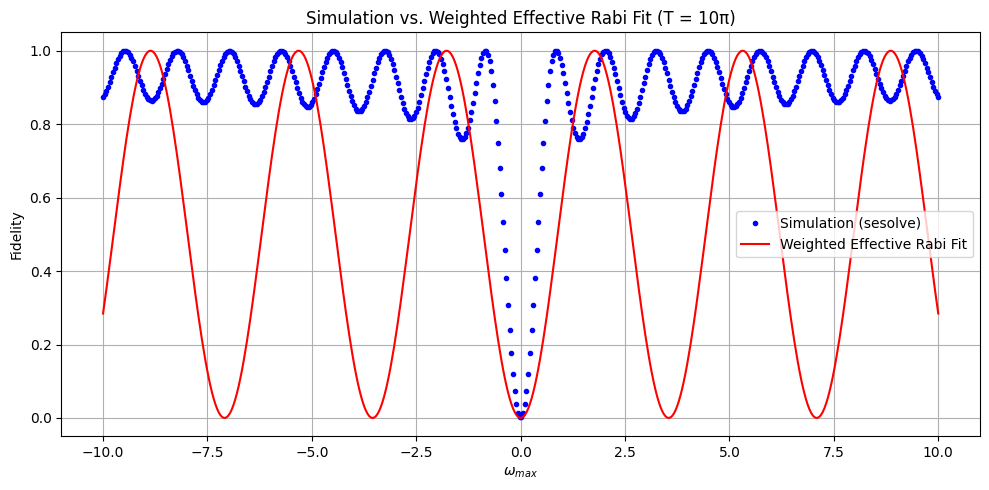

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmax, sigmaz, sesolve
from tqdm import tqdm

# Use T_max as an integer multiple of π (here 10π)
multiplier = 10
T_max = multiplier * np.pi
T = T_max  # Simulation final time

sigma = 1         # Gaussian pulse width
scale = 10        # Detuning scale

# Define Qutip operators and states
X = sigmax()
Z = sigmaz()
zero = basis(2, 0)
one = (X * zero).unit()
P1 = one * one.dag()

# Time grid
times = np.linspace(0, T, 50)

# Pulse definitions
def omega_t_func(om, t):
    return om * np.exp(-0.5 * ((t - T_max/2) / sigma)**2)

def delta_t_func(t):
    return scale * (t / (T_max/2) - 1)

# Precompute Gaussian envelope and its area for weighting
env = np.exp(-0.5 * ((times - T_max/2) / sigma)**2)
tau_eff = np.trapz(env, times)

# Compute effective detuning weighted by the envelope
eff_delta_val = np.trapz(delta_t_func(times) * env, times) / tau_eff

# Run simulation over a range of omega_max values
omega_maxs = np.linspace(-10, 10, 500)
sim_fidelity = []

for om in tqdm(omega_maxs, desc="Running sesolve"):
    # Define time-dependent functions for given om
    omega_t = lambda t: omega_t_func(om, t)
    delta_t = lambda t: delta_t_func(t)
    H = lambda t, args: X * omega_t(t) + Z * delta_t(t)
    result = sesolve(H, zero, times, e_ops=[P1])
    sim_fidelity.append(result.expect[0][-1])

# Compute weighted effective drive for each om using the Gaussian envelope
def effective_omega(om):
    pulse = omega_t_func(om, times)
    return np.trapz(pulse * env, times) / tau_eff

# Compute the effective Rabi angle and population transfer
def rabi_population(tau, eff_Omega, eff_delta):
    # Use the effective pulse area (weighted by the Gaussian)
    theta_eff = 0.5 * tau * np.sqrt(eff_Omega**2 + eff_delta**2)
    return (eff_Omega**2 / (eff_Omega**2 + eff_delta**2)) * np.sin(theta_eff)**2

theo_fidelity = []
for om in omega_maxs:
    eff_Omega = effective_omega(om)
    pop = rabi_population(tau_eff, eff_Omega, eff_delta_val)
    theo_fidelity.append(pop)

# Plot simulation versus improved theoretical fit
plt.figure(figsize=(10, 5))
plt.plot(omega_maxs, sim_fidelity, 'b.', label="Simulation (sesolve)")
plt.plot(omega_maxs, theo_fidelity, 'r-', label="Weighted Effective Rabi Fit")
plt.xlabel(r'$\omega_{max}$')
plt.ylabel("Fidelity")
plt.title("Simulation vs. Weighted Effective Rabi Fit (T = 10π)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()